Install Necessary Libraries

pip install numpy
pip install pandas
pip install matplotlib
pip install seaborn
pip install scikit-learn
pip install catboost
pip install xgboost

Import Necessary Libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

Load the Dataset

In [2]:
file_path = 'Rotten_Tomatoes_Movies3.XLSX' 
sheet_name = 'Rotten_Tomatoes_Movies(3)'
#Read the sheet into a df
df = pd.read_excel(file_path, sheet_name=sheet_name)
#Display the sample
df.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0


Exploratory Data Analysis:To understand the dataset, we look at the column names, non-null counts, and data types. This helps us identify any missing values or data issues early

In [3]:
#Creating a DataFrame to summarize col information
dataset_summary = pd.DataFrame({"Column Name": df.columns,
    "Non-Null Values": df.notnull().sum(),
    "Data Type": df.dtypes})
print("Dataset Summary:", dataset_summary)
#Calculate and displaying statistics for numeric columns
numeric_summary = df.describe()
print("Summary of Numeric Columns:", numeric_summary)


Dataset Summary:                            Column Name  Non-Null Values       Data Type
movie_title                movie_title            16638          object
movie_info                  movie_info            16614          object
critics_consensus    critics_consensus             8309          object
rating                          rating            16638          object
genre                            genre            16621          object
directors                    directors            16524          object
writers                        writers            15289          object
cast                              cast            16354          object
in_theaters_date      in_theaters_date            15823  datetime64[ns]
on_streaming_date    on_streaming_date            16636  datetime64[ns]
runtime_in_minutes  runtime_in_minutes            16483         float64
studio_name                studio_name            16222          object
tomatometer_status  tomatometer_status         

Visualising the data to explore relationships and distributions within the data 

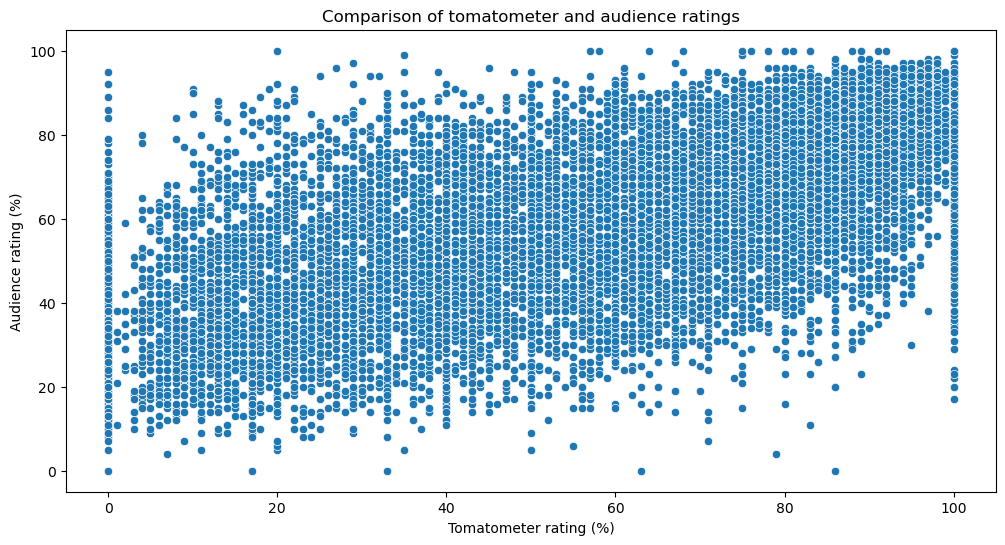

In [24]:
#Scatter plot for comparing tomatometer and audience ratings
plt.figure(figsize=(12, 6))
sns.scatterplot(x="tomatometer_rating", y="audience_rating", data=df)
plt.title("Comparison of tomatometer and audience ratings")
plt.xlabel("Tomatometer rating (%)")
plt.ylabel("Audience rating (%)")
plt.show()

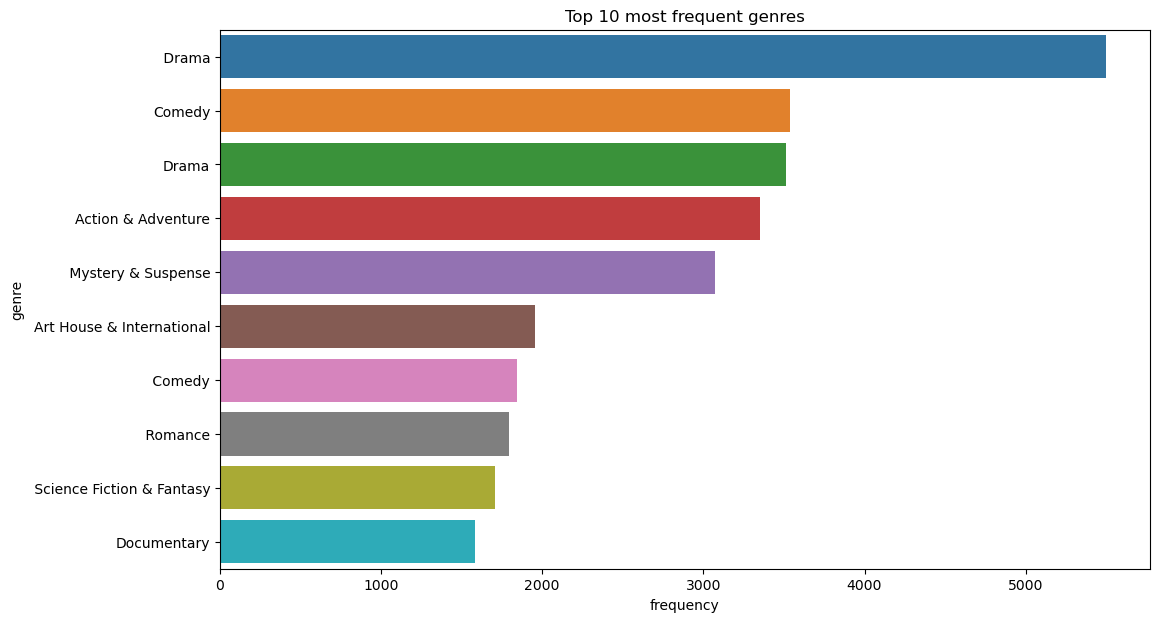

In [25]:
#Plotting the top 10 genres by frequency
plt.figure(figsize=(12, 7))
# Splitting,and counting genres
top_genres=df["genre"].str.split(",").explode().value_counts().head(10)
#  horizontal bar plot
sns.barplot(x=top_genres.values,y=top_genres.index,orient="h")
plt.title("Top 10 most frequent genres")
plt.xlabel("frequency")
plt.ylabel("genre")
plt.show()


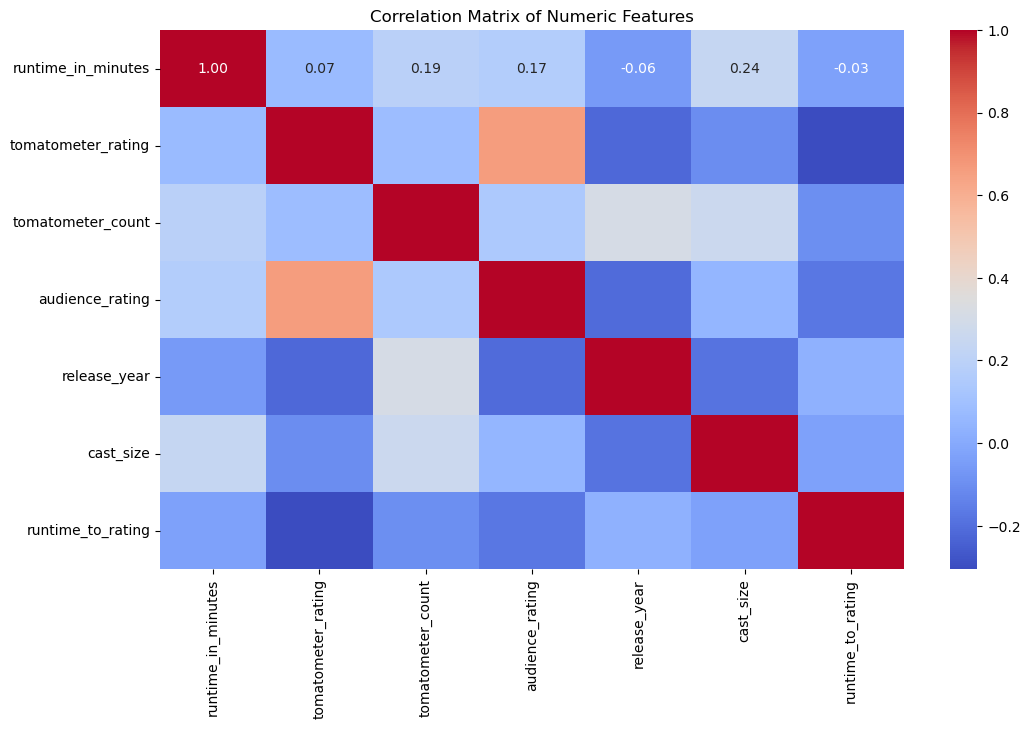

In [26]:
# Correlation matrix for numeric-columns
numeric_columns = df.select_dtypes(include=[np.number])  #Select numeric columns
plt.figure(figsize=(12, 7))
sns.heatmap(numeric_columns.corr(),annot=True,fmt=".2f",cmap="coolwarm",cbar=True)
plt.title("Correlation Matrix of Numeric Features")
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


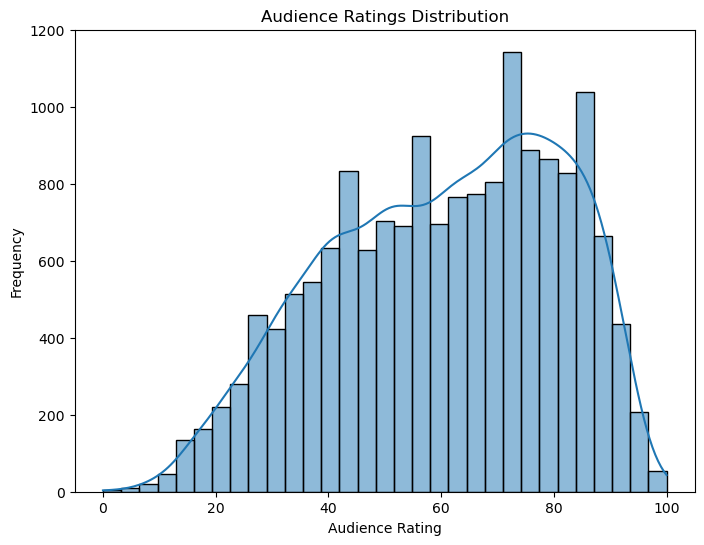

In [13]:
#Distribution-audience ratings
plt.figure(figsize=(8, 6))
sns.histplot(df["audience_rating"],bins=31,kde=True)
plt.title("Audience Ratings Distribution")
plt.xlabel("Audience Rating")
plt.ylabel("Frequency")
plt.show()


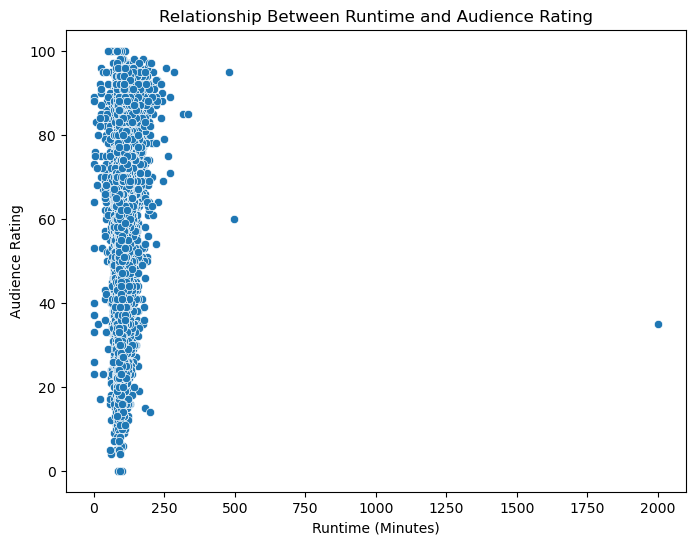

In [14]:
#Scatter plot -runtime vs audience rating
plt.figure(figsize=(8, 6))

sns.scatterplot(x="runtime_in_minutes", y="audience_rating", data=df)
plt.title("Relationship Between Runtime and Audience Rating")
plt.xlabel("Runtime (Minutes)")
plt.ylabel("Audience Rating")
plt.show()


Feature Engineering:Enhance the dataset by creating new features that provide additional insights or better represent the data

In [22]:
df["primary_genre"]=df["genre"].str.split(",").str[0]
df["release_year"]=pd.to_datetime(df["in_theaters_date"], errors="coerce").dt.year
df["cast_size"]=df["cast"].apply(lambda cast: len(str(cast).split(",")) if pd.notnull(cast) else 0)
df["runtime_to_rating"]=df["runtime_in_minutes"] / (df["tomatometer_rating"] + 1e-9)


In [16]:
df.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,primary_genre,release_year,cast_size,runtime_to_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0,Action & Adventure,2010.0,87,1.693878
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0,Comedy,2010.0,8,1.046512
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0,Comedy,1979.0,46,1.735294
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0,Classics,1957.0,16,0.950000
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0,Action & Adventure,1954.0,16,1.426966


In [17]:
df.shape

(16638, 20)

In [21]:
df["cast"]=df["cast"].fillna("unknown")

Picking the most relevant features based on domain knowledge and initial data exploration

In [20]:
selected_features=["primary_genre", "rating", "runtime_in_minutes", "studio_name",
    "tomatometer_rating", "tomatometer_count", "release_year", "runtime_to_rating", "cast_size", "cast"]
X=df[selected_features]
y=df["audience_rating"].fillna(df["audience_rating"].mean())
# Convert categorical columns to str
categorical_cols=["primary_genre", "rating", "studio_name", "cast"]
numerical_cols=[col for col in X.columns if col not in categorical_cols]
for col in categorical_cols:
    X.loc[:, col]=X[col].astype(str)

Data Preprocessing : Preparing the data set for training by handling missing values and encoding categorical variables


In [27]:
preprocessor = ColumnTransformer(
    transformers=[("num", Pipeline([("imputer", SimpleImputer(strategy="mean")),("scaler", StandardScaler())]), numerical_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))]), categorical_cols)])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=22)

Now lets Train and evaluate the models to find the best fit for this data set and it will be judged based on the R SQUARED,RMSE AND MAE

1.Linear Regression with Hyperparameter tuning

In [31]:
linear_pipeline = Pipeline([("preprocessor", preprocessor),("model", LinearRegression())])
linear_pipeline.fit(X_train, y_train)
y_pred_linear = linear_pipeline.predict(X_test)
print("Linear Regression:")
print("MAE:", mean_absolute_error(y_test, y_pred_linear))
print("RMSE:", mean_squared_error(y_test, y_pred_linear, squared=False))
print("R²:", r2_score(y_test, y_pred_linear))

Linear Regression:
MAE: 15.98773726140896
RMSE: 20.50791070858191
R²: -0.043518622144030905


In [36]:
param_grid = {"model__fit_intercept": [True, False]}

linear_pipeline = Pipeline([("preprocessor", preprocessor),("model", LinearRegression())])

grid_search = GridSearchCV(linear_pipeline, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_lr = grid_search.best_estimator_
y_pred_linear = best_lr.predict(X_test)

# Metrics for Linear Regression
print("Linear Regression (Tuned):")
print("MAE:", mean_absolute_error(y_test, y_pred_linear))
print("RMSE:", mean_squared_error(y_test, y_pred_linear, squared=False))
print("R²:", r2_score(y_test, y_pred_linear))

Linear Regression (Tuned):
MAE: 16.004893347065593
RMSE: 20.53082832559425
R²: -0.04585219214705649


2.Random Forest Regression without Hyperparameter Tuning

In [55]:
rf_pipeline = Pipeline([("preprocessor", preprocessor),("model", RandomForestRegressor(random_state=22))])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
print("Random Forest:")
print("MAE:",mean_absolute_error(y_test,y_pred_rf))
print("RMSE:",mean_squared_error(y_test,y_pred_rf,squared=False))
print("R²:",r2_score(y_test,y_pred_rf))

Random Forest:
MAE: 10.70852247088165
RMSE: 13.868530866142624
R²: 0.5227803885045388


3.XGBoost Regression without Hyperparameter Tuning

In [54]:
xgb_pipeline = Pipeline([("preprocessor", preprocessor),("model", XGBRegressor(random_state=22))])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
print("XGBoost:")
print("MAE:",mean_absolute_error(y_test,y_pred_xgb))
print("RMSE:",mean_squared_error(y_test,y_pred_xgb,squared=False))
print("R²:",r2_score(y_test,y_pred_xgb))

XGBoost:
MAE: 10.649502109484867
RMSE: 13.618763483525795
R²: 0.5398147195818512


4.Gradient Boosting Regression without Hyperparameter Tuning

In [56]:
gb_pipeline = Pipeline([("preprocessor",preprocessor),("model",GradientBoostingRegressor(random_state=22))])
gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)
print("Gradient Boosting:")
print("MAE:",mean_absolute_error(y_test,y_pred_gb))
print("RMSE:",mean_squared_error(y_test,y_pred_gb, squared=False))
print("R²:",r2_score(y_test,y_pred_gb))

Gradient Boosting:
MAE: 10.871730635479828
RMSE: 13.758371518910476
R²: 0.530331500557625


5.Catboost model without Hyperparameter Tuning

In [52]:
cat_pipeline = Pipeline([("preprocessor",preprocessor),("model",CatBoostRegressor(verbose=0,random_state=42))])
cat_pipeline.fit(X_train,y_train)
y_pred_cat = cat_pipeline.predict(X_test)
print("CatBoost:")
print("MAE:",mean_absolute_error(y_test,y_pred_cat))
print("RMSE:",mean_squared_error(y_test,y_pred_cat,squared=False))
print("R²:",r2_score(y_test,y_pred_cat))

CatBoost:
MAE: 10.559684690518724
RMSE: 13.458707636337722
R²: 0.5505679020119577


6.As CatBoost and XGBoost gives out the optimal metrics we will build a stacked regressor model which combines both the top 2 models and compare the results

In [60]:
from sklearn.ensemble import StackingRegressor
stacking_model = StackingRegressor(
    estimators=[("xgb", XGBRegressor(random_state=20)),("cat", CatBoostRegressor(verbose=0, random_state=20))],final_estimator=LinearRegression())
stacking_pipeline = Pipeline([("preprocessor", preprocessor),("model", stacking_model)])
stacking_pipeline.fit(X_train, y_train)
y_pred_stack=stacking_pipeline.predict(X_test)
print("Stacking Regressor:")
print("MAE:", mean_absolute_error(y_test, y_pred_stack))
print("RMSE:", mean_squared_error(y_test, y_pred_stack, squared=False))
print("R²:", r2_score(y_test, y_pred_stack))

Stacking Regressor:
MAE: 10.5346742751929
RMSE: 13.442779875020413
R²: 0.551631036977356


As we can see that this model has given us the most optimal metrics this model's performance is pretty good so lets try fine tuning the model by hyperparameterisation

In [62]:
from sklearn.linear_model import Ridge
stacking_param_grid = {
    "model__final_estimator__alpha": [10, 15, 20],
    "model__xgb__learning_rate": [0.01, 0.1],
    "model__xgb__n_estimators": [100, 200],
    "model__cat__depth": [6, 8]
}
stacking_model = StackingRegressor(
    estimators=[("xgb", XGBRegressor(random_state=22)),("cat", CatBoostRegressor(verbose=0, random_state=22))],final_estimator=Ridge(alpha=1.0))

stacking_pipeline = Pipeline([("preprocessor", preprocessor),("model", stacking_model)])
grid_search_stack = GridSearchCV(stacking_pipeline, stacking_param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search_stack.fit(X_train, y_train)
best_stacking_model = grid_search_stack.best_estimator_
y_pred_stack = best_stacking_model.predict(X_test)
print("Stacking Regressor (Hyperparameterized):")
print("MAE:", mean_absolute_error(y_test, y_pred_stack))
print("RMSE:", mean_squared_error(y_test, y_pred_stack, squared=False))
print("R²:", r2_score(y_test, y_pred_stack))

Stacking Regressor (Hyperparameterized):
MAE: 10.499274076119011
RMSE: 13.404012644829432
R²: 0.5542133836666466


So the Stacking regressor model is a good model with great R-Square ,RMSE and MAE values